# **Subtask B**

In [ ]:
import spacy
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from sklearn import preprocessing, linear_model, model_selection, neighbors, svm, naive_bayes, metrics, tree
from spacy import displacy
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# instantiates the spacy language module
nlp = spacy.load("en_core_web_sm")

In [ ]:
# call and display the dataframe
tweets_df = pd.read_csv('drive/My Drive/OLIDv1.0/olid-training-v1.0.tsv', delimiter="\t")
tweets_df.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [ ]:
# size of the dataset
len(tweets_df)

13240

In [ ]:
# changes the dataframe index to the tweet id
tweets_df = tweets_df.set_index('id')

In [ ]:
# display information about the dataframe
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13240 entries, 86426 to 46552
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      13240 non-null  object
 1   subtask_a  13240 non-null  object
 2   subtask_b  4400 non-null   object
 3   subtask_c  3876 non-null   object
dtypes: object(4)
memory usage: 517.2+ KB


In [ ]:
# storing dtype before operation 
dtype_before = type(tweets_df["tweet"]) 
  
# converting to list 
tweet_list = tweets_df["tweet"].tolist() 
  
# storing dtype after operation 
dtype_after = type(tweet_list) 

# stores the tweets in a list
doc = nlp(tweet_list[0])

In [ ]:
# shows the first tweet in the list
doc

@USER She should ask a few native Americans what their take on this is.

In [ ]:
# shows the tweet split up into indivdual sections
[token.text for token in doc]

['@USER',
 'She',
 'should',
 'ask',
 'a',
 'few',
 'native',
 'Americans',
 'what',
 'their',
 'take',
 'on',
 'this',
 'is',
 '.']

**Pre-Processing the Dataset**

In [ ]:
tweets_df.drop(['subtask_a', 'subtask_c'], axis = 1, inplace = True, errors = 'ignore')
tweets_df.head()

,tweet,subtask_b
id,,
86426,@USER She should ask a few native Americans wh...,UNT
90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,TIN
16820,Amazon is investigating Chinese employees who ...,NaN
62688,"@USER Someone should'veTaken"" this piece of sh...",UNT
43605,@USER @USER Obama wanted liberals &amp; illega...,NaN


In [ ]:
tweets_df = tweets_df.dropna()

In [ ]:
tweets_df.head()

,tweet,subtask_b
id,,
86426,@USER She should ask a few native Americans wh...,UNT
90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,TIN
62688,"@USER Someone should'veTaken"" this piece of sh...",UNT
97670,@USER Liberals are all Kookoo !!!,TIN
77444,@USER @USER Oh noes! Tough shit.,UNT


In [ ]:
le = LabelEncoder()
tweets_df['subtask_b'] = le.fit_transform(tweets_df['subtask_b']) 
tweets_df.head()

,tweet,subtask_b
id,,
86426,@USER She should ask a few native Americans wh...,1
90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,0
62688,"@USER Someone should'veTaken"" this piece of sh...",1
97670,@USER Liberals are all Kookoo !!!,0
77444,@USER @USER Oh noes! Tough shit.,1


In [ ]:
# method that will remove @USER tags from the data
def remove_pattern(input_txt, pattern):
  r = re.findall(pattern, input_txt)
  for i in r:
    input_txt = re.sub(i, '', input_txt)

  return input_txt

# tags are removed and a new dataset without them is saved
tweets_df['tweet'] = np.vectorize(remove_pattern)(tweets_df['tweet'], "@[\w]*")

# URL links had been changes to 'URL' so they have been removed as they're unnecessary
tweets_df['tweet'] = np.vectorize(remove_pattern)(tweets_df['tweet'], "URL")

In [ ]:
# removes useless emoticons and punctuation
tweets_df['tweet'] = tweets_df['tweet'].str.replace("[^a-zA-Z#']", " " )

In [ ]:
# displays the processed data without tags, URL or useless punctuation
tweets_df.head()

,tweet,subtask_b
id,,
86426,She should ask a few native Americans what th...,1
90194,Go home you re drunk #MAGA #Trump,0
62688,Someone should'veTaken this piece of shit to...,1
97670,Liberals are all Kookoo,0
77444,Oh noes Tough shit,1


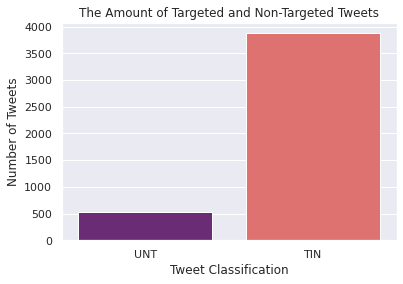

In [ ]:
barData = pd.read_csv('drive/My Drive/OLIDv1.0/olid-training-v1.0.tsv', delimiter="\t")
sns.countplot(x = 'subtask_b',  data = barData, palette = 'magma')
plt.ylabel('Number of Tweets')
plt.xlabel('Tweet Classification')
plt.title('The Amount of Targeted and Non-Targeted Tweets')
plt.show()

**Machine Learning using the Bag-of-Words Method**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# create a count vector to extract the words as bag-of-words
bow_vect = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# transform the tweets into the vectorisation
bow = bow_vect.fit_transform(tweets_df['tweet'])

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score

# create the training and testing bag-of-words
train_bow = bow[:13240, :] #31962
test_bow = bow[13240:, :]

# set up a training and testing split 
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, tweets_df['subtask_b'], random_state=42, test_size=0.2)

# instantiate the logistic regression function
lreg = LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=9999)
lreg.fit(xtrain_bow, ytrain)

# set up the predictions
prediction = lreg.predict_proba(xvalid_bow)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

In [ ]:
# calculate the baseline accuracy
baseline_predictions = [1 for x in yvalid]
metrics.accuracy_score(yvalid, baseline_predictions)

0.12727272727272726

In [ ]:
# display the logistic regression f1 prediction
f1_score(yvalid, prediction_int)

0.21538461538461537

In [ ]:
# prediction accuracy
metrics.accuracy_score(yvalid, prediction_int)

0.8261363636363637

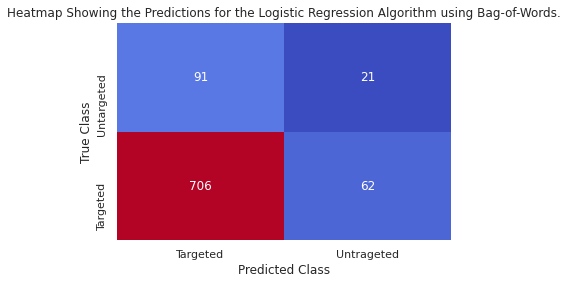

In [ ]:
# set up a heatmap to visualise the predictions of the logistic regression algorithm
cm = metrics.confusion_matrix(yvalid, prediction_int, labels = [0, 1])
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',cbar=False, ax=ax)
ax.set_xticklabels(['Targeted','Untrageted'])
ax.set_yticklabels(['Targeted','Untargeted'])
ax.set_xlabel('Predicted Class')
ax.set_title('Heatmap Showing the Predictions for the Logistic Regression Algorithm using Bag-of-Words.')
# I had to offset the ylim because matplotlib's newest update has caused them to go wonky otherwise
ax.set_ylim([0,2])
ax.set_ylabel('True Class');

In [ ]:
# instantiate some machine learning functions
classifiers = [neighbors.KNeighborsClassifier(),
               naive_bayes.MultinomialNB(),
               linear_model.LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=9999),
               tree.DecisionTreeClassifier(),
               linear_model.SGDClassifier(loss="log", penalty="l2", max_iter=50),
               MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(20, 20, 20), learning_rate='constant',
               learning_rate_init=0.001, max_iter=500, momentum=0.9,
               nesterovs_momentum=True, power_t=0.5, random_state=None,
               shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
               verbose=False, warm_start=False)]

classifier_names = ['KNN','Multinomial NB','Logistic', 'Decision Tree', 'SGD', 'MLP']
accuracies_bow = []
f1_bow = []
macro_bow = []
# iterate through the loop, training and fitting the tweet data
for clf, name in zip(classifiers,classifier_names):
    clf.fit(xtrain_bow, ytrain)
    prediction = clf.predict_proba(xvalid_bow)
    prediction_int = prediction[:,1] >= 0.3
    prediction_int = prediction_int.astype(np.int)
    acc = metrics.accuracy_score(yvalid, prediction_int)
    accuracies_bow.append(acc)
    f1 = f1_score(yvalid, prediction_int)
    f1_bow.append(f1)
    macro = f1_score(yvalid, prediction_int, average='macro')
    macro_bow.append(macro)
# save the accuracies in a DataFrame
models_bow = pd.DataFrame({'Model':classifier_names, 'Accuracy Baseline':accuracies_bow}) 

In [ ]:
# save the f1 scores to a dataframe
models_bow_f1 = pd.DataFrame({'Model':classifier_names, 'F1 Baseline':f1_bow})

**Machine Learning using the TF-IDF Method**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# create a count vector to extract the words as TF-IDF
tfidf_vect = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# transform the tweets into the vectorisation
tfidf = tfidf_vect.fit_transform(tweets_df['tweet'])

In [ ]:
# create the training and testing tfidf sets
train_tfidf = tfidf[:13240, :] #31962
test_tfidf = tfidf[13240:, :]

# set up a training and testing split 
xtrain_tfidf, xvalid_tfidf, ytrain_tfidf, yvalid_tfidf = train_test_split(train_tfidf, tweets_df['subtask_b'], random_state=42, test_size=0.2)

# instantiate the logistic regression function
lreg = linear_model.SGDClassifier(loss="log", penalty="l2", max_iter=50)#LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=9999)
lreg.fit(xtrain_tfidf, ytrain_tfidf)

# set up the predictions
prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

In [ ]:
# display the model accuracy
metrics.accuracy_score(yvalid_tfidf, prediction_int)

0.8409090909090909

In [ ]:
# display the logistic regression f1 prediction
f1_score(yvalid_tfidf, prediction_int)

0.21348314606741575

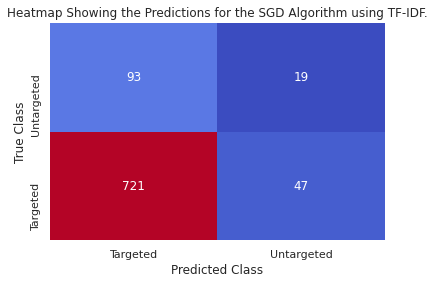

In [ ]:
# set up a heatmap to visualise the predictions of the logistic regression algorithm
cm = metrics.confusion_matrix(yvalid_tfidf, prediction_int, labels = [0, 1])
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',cbar=False, ax=ax)
ax.set_xticklabels(['Targeted','Untargeted'])
ax.set_yticklabels(['Targeted','Untargeted'])
ax.set_xlabel('Predicted Class')
ax.set_title('Heatmap Showing the Predictions for the SGD Algorithm using TF-IDF.')
# I had to offset the ylim because matplotlib's newest update has caused them to go wonky otherwise
ax.set_ylim([0,2])
ax.set_ylabel('True Class');

In [ ]:
# instantiate some machine learning functions
classifiers = [neighbors.KNeighborsClassifier(),
               naive_bayes.MultinomialNB(),
               linear_model.LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=9999),
               tree.DecisionTreeClassifier(),
               linear_model.SGDClassifier(loss="log", penalty="l2", max_iter=50),
               MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(20, 20, 20), learning_rate='constant',
               learning_rate_init=0.001, max_iter=500, momentum=0.9,
               nesterovs_momentum=True, power_t=0.5, random_state=None,
               shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
               verbose=False, warm_start=False)]

classifier_names = ['KNN','Multinomial NB','Logistic', 'Decision Tree', 'SGD', 'MLP']
accuracies_tfidf = []
tfidf_f1 = []
tfidf_macro = []
# iterate through the loop, training and fitting the tweet data
for clf, name in zip(classifiers,classifier_names):
    clf.fit(xtrain_tfidf, ytrain_tfidf)
    prediction = clf.predict_proba(xvalid_tfidf)
    prediction_int = prediction[:,1] >= 0.3
    prediction_int = prediction_int.astype(np.int)
    acc = metrics.accuracy_score(yvalid_tfidf, prediction_int)
    accuracies_tfidf.append(acc)
    f1 = f1_score(yvalid_tfidf, prediction_int)
    tfidf_f1.append(f1)
    macro = f1_score(yvalid_tfidf, prediction_int, average='macro')
    tfidf_macro.append(macro)
# save the accuracies in a DataFrame
models_tfidf = pd.DataFrame({'Model':classifier_names, 'Accuracy Baseline':accuracies_tfidf})  

In [ ]:
# f1 scores
models_tfidf = pd.DataFrame({'Model':classifier_names, 'F1 Baseline':tfidf_f1}) 

In [ ]:
# accuracies of the algorithms for the two methods
models = pd.DataFrame({'Model':classifier_names, 'Bag-of-Words Accuracy':accuracies_bow, 'TF-IDF Accuracy':accuracies_tfidf}) 

In [ ]:
models_all = pd.DataFrame({'Model':classifier_names, 'BoW Accuracy': accuracies_bow, 'TF-IDF Accuracy': accuracies_tfidf, 'BoW F1':f1_bow, 'TF-IDF F1':tfidf_f1, 'BoW Macro F1':macro_bow, 'TF-IDF Macro F1':tfidf_macro})

# comparison between the f1 scores and accuracies of all algorithms between the two methods
models_all

,Model,BoW Accuracy,TF-IDF Accuracy,BoW F1,TF-IDF F1,BoW Macro F1,TF-IDF Macro F1
0,KNN,0.690909,0.686364,0.264865,0.211429,0.534591,0.507842
1,Multinomial NB,0.819318,0.868182,0.286996,0.049180,0.591774,0.489181
2,Logistic,0.826136,0.860227,0.215385,0.115108,0.558811,0.519614
3,Decision Tree,0.761364,0.802273,0.265734,0.201835,0.561632,0.544497
4,SGD,0.797727,0.840909,0.276423,0.230769,0.579427,0.571025
5,MLP,0.805682,0.818182,0.211982,0.215686,0.550579,0.556429


**Maximum Absolute Scaling of the Bag-of-Words Data**

In [ ]:
scalerminmax = preprocessing.MaxAbsScaler()
scalerminmax.fit(xtrain_bow)
X_train_scaled_minmax_bow = scalerminmax.transform(xtrain_bow)
X_train_scaled_minmax_bow[0]

<1x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [ ]:
# instantiate some machine learning functions
classifiers = [neighbors.KNeighborsClassifier(),
               naive_bayes.MultinomialNB(),
               linear_model.LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=9999),
               tree.DecisionTreeClassifier(),
               linear_model.SGDClassifier(loss="log", penalty="l2", max_iter=50),
               MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(20, 20, 20), learning_rate='constant',
               learning_rate_init=0.001, max_iter=500, momentum=0.9,
               nesterovs_momentum=True, power_t=0.5, random_state=None,
               shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
               verbose=False, warm_start=False)]

classifier_names = ['KNN','Multinomial NB','Logistic', 'Decision Tree', 'SGD', 'MLP']
X_valid_scaled_normal_bow = scalerminmax.transform(xvalid_bow)
accuracies_bow_normal = []
f1_bow_normal = []
macro_bow_normal = []
# iterate through the loop, training and fitting the tweet data
for clf, name in zip(classifiers,classifier_names):
    clf.fit(X_train_scaled_minmax_bow, ytrain)
    prediction = clf.predict_proba(X_valid_scaled_normal_bow)
    prediction_int = prediction[:,1] >= 0.3
    prediction_int = prediction_int.astype(np.int)
    acc_bow_max = metrics.accuracy_score(yvalid, prediction_int)
    accuracies_bow_normal.append(acc_bow_max)
    f1_bow_max = f1_score(yvalid, prediction_int)
    f1_bow_normal.append(f1_bow_max)
    macro_bow_norm = f1_score(yvalid, prediction_int, average='macro')
    macro_bow_normal.append(macro_bow_norm)
# save the accuracies in a DataFrame
models_bow_normal = pd.DataFrame({'model':classifier_names, 'MaxAbScaled':accuracies_bow_normal})    
#models_bow_normal

**Standardisation of the Bag-of-Words Data**

In [ ]:
# scale the data using standardisation
scaler = preprocessing.StandardScaler(with_mean=False)
scaler.fit(xtrain_bow)
# transform and scale the data
X_train_standard_bow = scaler.transform(xtrain_bow)
X_train_standard_bow[0]

<1x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [ ]:
# instantiate some machine learning functions
classifiers = [neighbors.KNeighborsClassifier(),
               naive_bayes.MultinomialNB(),
               linear_model.LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=9999),
               tree.DecisionTreeClassifier(),
               linear_model.SGDClassifier(loss="log", penalty="l2", max_iter=50),
               MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(20, 20, 20), learning_rate='constant',
               learning_rate_init=0.001, max_iter=500, momentum=0.9,
               nesterovs_momentum=True, power_t=0.5, random_state=None,
               shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
               verbose=False, warm_start=False)]

classifier_names = ['KNN','Multinomial NB','Logistic', 'Decision Tree', 'SGD', 'MLP']
X_valid_scaled_standard_bow = scaler.transform(xvalid_bow)
accuracies_bow_standard = []
f1_bow_standard = []
macro_bow_standard = []
# iterate through the loop, training and fitting the tweet data
for clf, name in zip(classifiers,classifier_names):
    clf.fit(X_train_standard_bow, ytrain)
    prediction = clf.predict_proba(X_valid_scaled_standard_bow)
    prediction_int = prediction[:,1] >= 0.3
    prediction_int = prediction_int.astype(np.int)
    acc_bow_stan = metrics.accuracy_score(yvalid, prediction_int)
    accuracies_bow_standard.append(acc_bow_stan)
    f1_bow_stan = f1_score(yvalid, prediction_int)
    f1_bow_standard.append(f1_bow_stan)
    macro_bow_stan = f1_score(yvalid, prediction_int, average='macro')
    macro_bow_standard.append(macro_bow_stan)
# save the accuracies in a DataFrame
models_tfidf_bow = pd.DataFrame({'model':classifier_names, 'standard':accuracies_bow_standard})    
#models_tfidf_bow

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


**Maximum Absolute Scaling of the TF-IDF Data**

In [ ]:
# scale the training data with maximum absolute scaling
scalerminmax = preprocessing.MaxAbsScaler()
scalerminmax.fit(xtrain_tfidf)
# transfrom and scale the data
X_train_scaled_minmax_tfidf = scalerminmax.transform(xtrain_tfidf)
X_train_scaled_minmax_tfidf[0]

<1x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [ ]:
# instantiate some machine learning functions
classifiers = [neighbors.KNeighborsClassifier(),
               naive_bayes.MultinomialNB(),
               linear_model.LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=9999),
               tree.DecisionTreeClassifier(),
               linear_model.SGDClassifier(loss="log", penalty="l2", max_iter=50),
               MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(20, 20, 20), learning_rate='constant',
               learning_rate_init=0.001, max_iter=500, momentum=0.9,
               nesterovs_momentum=True, power_t=0.5, random_state=None,
               shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
               verbose=False, warm_start=False)]

classifier_names = ['KNN','Multinomial NB','Logistic', 'Decision Tree', 'SGD', 'MLP']
X_valid_scaled_normal_tfidf = scalerminmax.transform(xvalid_tfidf)
accuracies_tfidf_normal = []
f1_tfidf_normal = []
macro_tfidf_normal = []
# iterate through the loop, training and fitting the tweet data
for clf, name in zip(classifiers,classifier_names):
    clf.fit(X_train_scaled_minmax_tfidf, ytrain_tfidf)
    # find the results
    prediction = clf.predict_proba(X_valid_scaled_normal_tfidf)
    prediction_int = prediction[:,1] >= 0.3
    prediction_int = prediction_int.astype(np.int)
    acc_tfidf_max = metrics.accuracy_score(yvalid_tfidf, prediction_int)
    accuracies_tfidf_normal.append(acc_tfidf_max)
    f1_tfidf_max = f1_score(yvalid_tfidf, prediction_int)
    f1_tfidf_normal.append(f1_tfidf_max)
    macro_tfidf_norm = f1_score(yvalid_tfidf, prediction_int, average='macro')
    macro_tfidf_normal.append(macro_tfidf_norm)
# save the accuracies in a DataFrame
models_tfidf_normal = pd.DataFrame({'model':classifier_names, 'MaxAbScaled':accuracies_tfidf_normal})    
#models_tfidf_normal

**Standardisation of the TF-IDF Data**

In [ ]:
scaler = preprocessing.StandardScaler(with_mean=False)
scaler.fit(xtrain_tfidf)
X_train_standard = scaler.transform(xtrain_tfidf)
X_train_standard[0]

<1x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [ ]:
# instantiate some machine learning functions
classifiers = [neighbors.KNeighborsClassifier(),
               naive_bayes.MultinomialNB(),
               linear_model.LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=9999),
               tree.DecisionTreeClassifier(),
               linear_model.SGDClassifier(loss="log", penalty="l2", max_iter=50),
               MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(20, 20, 20), learning_rate='constant',
               learning_rate_init=0.001, max_iter=500, momentum=0.9,
               nesterovs_momentum=True, power_t=0.5, random_state=None,
               shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
               verbose=False, warm_start=False)]

classifier_names = ['KNN','Multinomial NB','Logistic', 'Decision Tree', 'SGD', 'MLP']
X_valid_scaled_standard_tfidf = scaler.transform(xvalid_tfidf)
accuracies_tfidf_standard = []
f1_tfidf_standard = []
macro_tfidf_standard = []
# iterate through the loop, training and fitting the tweet data
for clf, name in zip(classifiers,classifier_names):
    clf.fit(X_train_standard, ytrain_tfidf)
    prediction = clf.predict_proba(X_valid_scaled_standard_tfidf)
    prediction_int = prediction[:,1] >= 0.3
    prediction_int = prediction_int.astype(np.int)
    acc_tfidf_stan = metrics.accuracy_score(yvalid_tfidf, prediction_int)
    accuracies_tfidf_standard.append(acc_tfidf_stan)
    f1_tfidf_stan = f1_score(yvalid_tfidf, prediction_int)
    f1_tfidf_standard.append(f1_tfidf_stan)
    macro_tfidf_stan = f1_score(yvalid_tfidf, prediction_int, average='macro')
    macro_tfidf_standard.append(macro_tfidf_stan)
# save the accuracies in a DataFrame
models_tfidf_standard = pd.DataFrame({'model':classifier_names, 'standard':accuracies_tfidf_standard})    
#models_tfidf_standard

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


**Accuracy Scores for the Default and Scaled Algorithms**

In [ ]:
# data frame showing all the scaled and unscaled algorithm results
models_acc = pd.DataFrame({'Model':classifier_names, 
                       'Bag-of-Words':accuracies_bow, 
                       'BoW MaxAbScaled': accuracies_bow_normal, 
                       'BoW Standardised':accuracies_bow_standard, 
                       'TF-IDF':accuracies_tfidf, 
                       'TF-IDF MaxAbScaled':accuracies_tfidf_normal, 
                       'TF-IDF Standardised':accuracies_tfidf_standard})    
models_acc

,Model,Bag-of-Words,BoW MaxAbScaled,BoW Standardised,TF-IDF,TF-IDF MaxAbScaled,TF-IDF Standardised
0,KNN,0.690909,0.687500,0.767045,0.686364,0.694318,0.725000
1,Multinomial NB,0.819318,0.839773,0.718182,0.868182,0.853409,0.717045
2,Logistic,0.826136,0.848864,0.770455,0.860227,0.850000,0.753409
3,Decision Tree,0.746591,0.752273,0.752273,0.806818,0.796591,0.801136
4,SGD,0.804545,0.828409,0.767045,0.839773,0.834091,0.761364
5,MLP,0.820455,0.819318,0.812500,0.815909,0.814773,0.823864


**F1 Scores for the Default and Scaled Algorithms**

In [ ]:
# data frame showing all the scaled and unscaled algorithm results
models_f1 = pd.DataFrame({'Model':classifier_names, 
                       'Bag-of-Words':f1_bow, 
                       'BoW MaxAbScaled': f1_bow_normal, 
                       'BoW Standardised':f1_bow_standard, 
                       'TF-IDF':tfidf_f1, 
                       'TF-IDF MaxAbScaled':f1_tfidf_normal, 
                       'TF-IDF Standardised':f1_tfidf_standard})    
models_f1

,Model,Bag-of-Words,BoW MaxAbScaled,BoW Standardised,TF-IDF,TF-IDF MaxAbScaled,TF-IDF Standardised
0,KNN,0.264865,0.220963,0.275618,0.211429,0.192192,0.229299
1,Multinomial NB,0.286996,0.145455,0.326087,0.049180,0.167742,0.321526
2,Logistic,0.215385,0.193939,0.234848,0.115108,0.185185,0.205128
3,Decision Tree,0.238908,0.253425,0.263514,0.212963,0.204444,0.208145
4,SGD,0.218182,0.241206,0.232210,0.245989,0.262626,0.166667
5,MLP,0.225490,0.208955,0.202899,0.235849,0.212560,0.236453


**Macro F1 Scores for the Default and Scaled Algorithms**

In [ ]:
# data frame showing all the scaled and unscaled algorithm results
models_macro_f1 = pd.DataFrame({'Model':classifier_names, 
                        'Bag-of-Words':macro_bow, 
                        'BoW MaxAbScaled': macro_bow_normal, 
                        'BoW Standardised':macro_bow_standard, 
                        'TF-IDF':tfidf_macro, 
                        'TF-IDF MaxAbScaled':macro_tfidf_normal, 
                        'TF-IDF Standardised':macro_tfidf_standard})    
models_macro_f1

,Model,Bag-of-Words,BoW MaxAbScaled,BoW Standardised,TF-IDF,TF-IDF MaxAbScaled,TF-IDF Standardised
0,KNN,0.534591,0.512756,0.568412,0.507842,0.501842,0.530971
1,Multinomial NB,0.591774,0.528527,0.573963,0.489181,0.543684,0.571387
2,Logistic,0.558811,0.555277,0.549911,0.519614,0.551291,0.529598
3,Decision Tree,0.543448,0.552462,0.557303,0.551430,0.543916,0.547217
4,SGD,0.553247,0.572237,0.547451,0.578176,0.584578,0.513705
5,MLP,0.561974,0.553483,0.548326,0.565599,0.553801,0.568451


**Parameter-Tuning for the TF-IDF Logistic Regression Algorithm**

In [ ]:
best = 0.0
best_f1 = 0.0
best_macro = 0.0
best_c = 0
best_solver = ''
best_multiclass = ''
# iterate through the parameter variables
for c in range(1,30):
    for solver in ['saga', 'newton-cg','lbfgs','sag']:
        for multiclass in ['ovr', 'multinomial', 'auto']:
                clf = linear_model.LogisticRegression(solver=solver, C=c, multi_class=multiclass, max_iter=9999)
                clf.fit(xtrain_tfidf, ytrain_tfidf)
                # set up the predictions
                prediction = clf.predict_proba(xvalid_tfidf)
                prediction_int = prediction[:,1] >= 0.3
                prediction_int = prediction_int.astype(np.int)
                acc = metrics.accuracy_score(yvalid_tfidf, prediction_int)
                f1 = f1_score(yvalid_tfidf, prediction_int)
                macro = f1_score(yvalid_tfidf, prediction_int, average='macro')
                # find the best parameters for the algorithm 
                if macro > best_macro:
                    best_macro = macro
                    best_c = c
                    best_solver = solver
                    best_multiclass = multiclass
                if acc > best:
                    best = acc
                if f1 > best_f1:
                    best_f1 = f1
print('Best Accuracy was '+str(best)+', the best Macro F1 was '+str(best_macro)+' and the best F1 was '+str(best_f1)+' using '+str(best_c)+' C, the '+str(best_solver)+' solver and using the multi class, '+str(best_multiclass))

Best Accuracy was 0.8613636363636363, the best Macro F1 was 0.5979334340842793 and the best F1 was 0.2972972972972973 using 11 C, the saga solver and using the multi class, ovr


**Parameter Tuning for the Bag-of-Words Logistic Regression Algorithm**

In [ ]:
best = 0.0
best_f1 = 0.0
best_macro = 0.0
best_c = 0
best_solver = ''
best_multiclass = ''
# iterate through the parameter variables
for c in range(1,30):
    for solver in ['saga', 'newton-cg','lbfgs','sag']:
        for multiclass in ['ovr', 'multinomial', 'auto']:
                clf = linear_model.LogisticRegression(solver=solver, C=c, multi_class=multiclass, max_iter=9999)
                clf.fit(xtrain_bow, ytrain)
                # set up the predictions
                prediction = clf.predict_proba(xvalid_bow)
                prediction_int = prediction[:,1] >= 0.3
                prediction_int = prediction_int.astype(np.int)
                acc = metrics.accuracy_score(yvalid, prediction_int)
                f1 = f1_score(yvalid, prediction_int)
                macro = f1_score(yvalid, prediction_int, average='macro')
                # find the best parameters for the algorithm 
                if macro > best_macro:
                    best_macro = macro
                    best_c = c
                    best_solver = solver
                    best_multiclass = multiclass
                if acc > best:
                    best = acc
                if f1 > best_f1:
                    best_f1 = f1
print('Best Accuracy was '+str(best)+', the best Macro F1 was '+str(best_macro)+' and the best F1 was '+str(best_f1)+' using '+str(best_c)+' C, the '+str(best_solver)+' solver and using the multi class, '+str(best_multiclass))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Best Accuracy was 0.8272727272727273, the best Macro F1 was 0.573559783549284 and the best F1 was 0.25663716814159293 using 3 C, the saga solver and using the multi class, ovr


**Parameter Tuning for the TF-IDF SGD**

In [ ]:
best = 0.0
best_f1 = 0.0
best_macro = 0.0
best_c = 0
best_solver = ''
best_multiclass = ''
# iterate through the parameter variables
for v in range(1,30):
    for penalty in ['l2', 'l1','elasticnet']:
        for lr in ['optimal']:
                clf = linear_model.SGDClassifier(loss='log', penalty=penalty, verbose=v, learning_rate=lr, max_iter=9999, shuffle=True)
                clf.fit(xtrain_tfidf, ytrain_tfidf)
                # set up the predictions
                prediction = clf.predict_proba(xvalid_tfidf)
                prediction_int = prediction[:,1] >= 0.3
                prediction_int = prediction_int.astype(np.int)
                acc = metrics.accuracy_score(yvalid_tfidf, prediction_int)
                f1 = f1_score(yvalid_tfidf, prediction_int)
                macro = f1_score(yvalid_tfidf, prediction_int, average='macro')
                # find the best parameters for the algorithm 
                if macro > best_macro:
                    best_macro = macro
                    best_v = v
                    best_penalty = penalty
                    best_lr = lr
                if acc > best:
                    best = acc
                if f1 > best_f1:
                    best_f1 = f1
print('Best Accuracy was '+str(best)+', the best Macro F1 was '+str(best_macro)+' and the best F1 was '+str(best_f1)+' using '+str(best_v)+' verbose, the '+str(best_penalty)+' penalty and using the learning rate, '+str(best_lr))

-- Epoch 1
Norm: 27.23, NNZs: 1000, Bias: -2.046970, T: 3520, Avg. loss: 0.416884
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 25.71, NNZs: 1000, Bias: -1.975542, T: 7040, Avg. loss: 0.314884
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 24.96, NNZs: 1000, Bias: -2.017597, T: 10560, Avg. loss: 0.293260
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 24.96, NNZs: 1000, Bias: -2.017361, T: 14080, Avg. loss: 0.285555
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 24.82, NNZs: 1000, Bias: -2.001549, T: 17600, Avg. loss: 0.280425
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 24.59, NNZs: 1000, Bias: -2.018760, T: 21120, Avg. loss: 0.276746
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 24.64, NNZs: 1000, Bias: -2.008256, T: 24640, Avg. loss: 0.274673
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 24.53, NNZs: 1000, Bias: -2.030723, T: 28160, Avg. loss: 0.272567
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 24.53, NNZs: 1000, Bias: -2.021400, T: 31

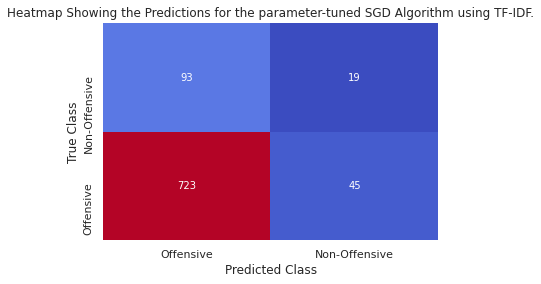

In [ ]:
# set up a heatmap to visualise the predictions of the parameter-tuned SGD algorithm
cm = metrics.confusion_matrix(yvalid_tfidf, prediction_int, labels = [0, 1])
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',cbar=False, ax=ax)
ax.set_xticklabels(['Offensive','Non-Offensive'])
ax.set_yticklabels(['Offensive','Non-Offensive'])
ax.set_xlabel('Predicted Class')
ax.set_title('Heatmap Showing the Predictions for the parameter-tuned SGD Algorithm using TF-IDF.')
# I had to offset the ylim because matplotlib's newest update has caused them to go wonky otherwise
ax.set_ylim([0,2])
ax.set_ylabel('True Class');

**Parameter Tuning for the Bag-of-Words SGD**

In [ ]:
best = 0.0
best_f1 = 0.0
best_macro = 0.0
best_c = 0
best_solver = ''
best_multiclass = ''
# iterate through the parameter variables
for v in range(1,30):
    for penalty in ['l2', 'l1','elasticnet']:
        for lr in ['optimal']:
                clf = linear_model.SGDClassifier(loss='log', penalty=penalty, verbose=v, learning_rate=lr, max_iter=9999, shuffle=True)
                clf.fit(xtrain_bow, ytrain)
                # set up the predictions
                prediction = clf.predict_proba(xvalid_bow)
                prediction_int = prediction[:,1] >= 0.3
                prediction_int = prediction_int.astype(np.int)
                acc = metrics.accuracy_score(yvalid, prediction_int)
                f1 = f1_score(yvalid, prediction_int)
                macro = f1_score(yvalid, prediction_int, average='macro')
                # find the best parameters for the algorithm 
                if macro > best_macro:
                    best_macro = macro
                    best_v = v
                    best_penalty = penalty
                    best_lr = lr
                if acc > best:
                    best = acc
                if f1 > best_f1:
                    best_f1 = f1
print('Best Accuracy was '+str(best)+', the best Macro F1 was '+str(best_macro)+' and the best F1 was '+str(best_f1)+' using '+str(best_v)+' verbose, the '+str(best_penalty)+' penalty and using the learning rate, '+str(best_lr))

Streaming output truncated to the last 5000 lines.
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 188.81, NNZs: 644, Bias: -1.592478, T: 45760, Avg. loss: 0.221859
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 188.94, NNZs: 641, Bias: -1.597284, T: 49280, Avg. loss: 0.216698
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 189.05, NNZs: 641, Bias: -1.590146, T: 52800, Avg. loss: 0.216025
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 189.17, NNZs: 641, Bias: -1.582237, T: 56320, Avg. loss: 0.214098
Total training time: 0.02 seconds.
-- Epoch 17
Norm: 189.29, NNZs: 636, Bias: -1.571232, T: 59840, Avg. loss: 0.212942
Total training time: 0.02 seconds.
-- Epoch 18
Norm: 189.39, NNZs: 637, Bias: -1.571740, T: 63360, Avg. loss: 0.212799
Total training time: 0.02 seconds.
-- Epoch 19
Norm: 189.50, NNZs: 639, Bias: -1.582377, T: 66880, Avg. loss: 0.212211
Total training time: 0.02 seconds.
-- Epoch 20
Norm: 189.60, NNZs: 641, Bias: -1.568424, T: 70400, Avg. loss: 0.2119

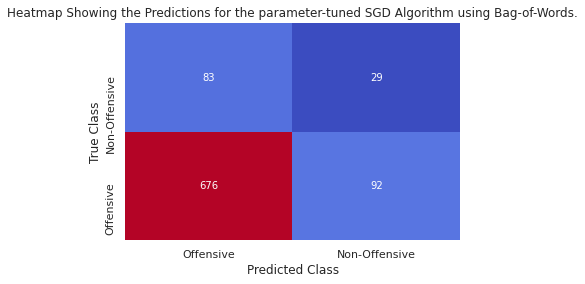

In [ ]:
# set up a heatmap to visualise the predictions of the parameter-tuned SGD algorithm
cm = metrics.confusion_matrix(yvalid, prediction_int, labels = [0, 1])
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',cbar=False, ax=ax)
ax.set_xticklabels(['Offensive','Non-Offensive'])
ax.set_yticklabels(['Offensive','Non-Offensive'])
ax.set_xlabel('Predicted Class')
ax.set_title('Heatmap Showing the Predictions for the parameter-tuned SGD Algorithm using Bag-of-Words.')
# I had to offset the ylim because matplotlib's newest update has caused them to go wonky otherwise
ax.set_ylim([0,2])
ax.set_ylabel('True Class');

**Parameter Tuning for the TF-IDF Logistic Regression Algorithm after MaxAbScaling**

In [ ]:
# scale the training data with maximum absolute scaling
scalerminmax = preprocessing.MaxAbsScaler()
scalerminmax.fit(xtrain_tfidf)
# transfrom and scale the data
X_train_scaled_minmax_tfidf = scalerminmax.transform(xtrain_tfidf)
X_train_scaled_minmax_tfidf[0]

<1x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [ ]:
best = 0.0
best_f1 = 0.0
best_macro = 0.0
best_c = 0
best_solver = ''
best_multiclass = ''
# iterate through the parameter variables
for c in range(1,30):
    for solver in ['saga', 'newton-cg','lbfgs','sag']:
        for multiclass in ['ovr', 'multinomial', 'auto']:
                clf = linear_model.LogisticRegression(solver=solver, C=c, multi_class=multiclass, max_iter=9999)
                clf.fit(X_train_scaled_minmax_tfidf, ytrain_tfidf)
                X_valid_scaled_normal_tfidf = scalerminmax.transform(xvalid_tfidf)
                # set up the predictions
                prediction = clf.predict_proba(X_valid_scaled_normal_tfidf)
                prediction_int = prediction[:,1] >= 0.3
                prediction_int = prediction_int.astype(np.int)
                acc = metrics.accuracy_score(yvalid_tfidf, prediction_int)
                f1 = f1_score(yvalid_tfidf, prediction_int)
                macro = f1_score(yvalid_tfidf, prediction_int, average='macro')
                # find the best parameters for the algorithm 
                if macro > best_macro:
                    best_macro = macro
                    best_c = c
                    best_solver = solver
                    best_multiclass = multiclass
                if acc > best:
                    best = acc
                if f1 > best_f1:
                    best_f1 = f1
print('Best Accuracy was '+str(best)+', the best Macro F1 was '+str(best_macro)+' and the best F1 was '+str(best_f1)+' using '+str(best_c)+' C, the '+str(best_solver)+' solver and using the multi class, '+str(best_multiclass))

Best Accuracy was 0.85, the best Macro F1 was 0.5827478296852505 and the best F1 was 0.27312775330396477 using 7 C, the saga solver and using the multi class, ovr


**Parameter Tuning for the TF-IDF SGD Algorithm after MaxAbScaling**

In [ ]:
# scale the training data with maximum absolute scaling
scalerminmax = preprocessing.MaxAbsScaler()
scalerminmax.fit(xtrain_tfidf)
# transfrom and scale the data
X_train_scaled_minmax_tfidf = scalerminmax.transform(xtrain_tfidf)
X_train_scaled_minmax_tfidf[0]

<1x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [ ]:
best = 0.0
best_f1 = 0.0
best_macro = 0.0
best_c = 0
best_solver = ''
best_multiclass = ''
# iterate through the parameter variables
for v in range(1,30):
    for penalty in ['l2', 'l1','elasticnet']:
        for lr in ['optimal']:
                clf = linear_model.SGDClassifier(loss='log', penalty=penalty, verbose=v, learning_rate=lr, max_iter=9999, shuffle=True)
                clf.fit(X_train_scaled_minmax_tfidf, ytrain_tfidf)
                X_valid_scaled_normal_tfidf = scalerminmax.transform(xvalid_tfidf)
                # set up the predictions
                prediction = clf.predict_proba(X_valid_scaled_normal_tfidf)
                prediction_int = prediction[:,1] >= 0.3
                prediction_int = prediction_int.astype(np.int)
                acc = metrics.accuracy_score(yvalid_tfidf, prediction_int)
                f1 = f1_score(yvalid_tfidf, prediction_int)
                macro = f1_score(yvalid_tfidf, prediction_int, average='macro')
                # find the best parameters for the algorithm 
                if macro > best_macro:
                    best_macro = macro
                    best_v = v
                    best_penalty = penalty
                    best_lr = lr
                if acc > best:
                    best = acc
                if f1 > best_f1:
                    best_f1 = f1
print('Best Accuracy was '+str(best)+', the best Macro F1 was '+str(best_macro)+' and the best F1 was '+str(best_f1)+' using '+str(best_v)+' verbose, the '+str(best_penalty)+' penalty and using the learning rate, '+str(best_lr))

-- Epoch 1
Norm: 35.58, NNZs: 1000, Bias: -2.204889, T: 3520, Avg. loss: 0.525502
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 30.13, NNZs: 1000, Bias: -2.022053, T: 7040, Avg. loss: 0.329575
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 27.98, NNZs: 1000, Bias: -2.028346, T: 10560, Avg. loss: 0.292091
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 27.19, NNZs: 1000, Bias: -2.044533, T: 14080, Avg. loss: 0.276288
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 26.88, NNZs: 1000, Bias: -2.030693, T: 17600, Avg. loss: 0.267505
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 26.63, NNZs: 1000, Bias: -1.999006, T: 21120, Avg. loss: 0.261878
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 26.52, NNZs: 1000, Bias: -2.012267, T: 24640, Avg. loss: 0.259747
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 26.42, NNZs: 1000, Bias: -2.021081, T: 28160, Avg. loss: 0.256015
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 26.29, NNZs: 1000, Bias: -2.032656, T: 31

**Recurrent Neural Network**

In [ ]:
import tensorflow as tf
# The maximum number of words to be used (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint
MAX_SEQUENCE_LENGTH = 250
# This is fixed
EMBEDDING_DIM = 100
# tokenise the tweets 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(tweets_df['tweet'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 10259 unique tokens.


In [ ]:
# find the sequence for all tweets in the dataset
X = tokenizer.texts_to_sequences(tweets_df['tweet'].values)
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
# find the tensor shape
print('Shape of data tensor:', X.shape)

Shape of data tensor: (4400, 250)


In [ ]:
# find the tensor shape for the categories
Y = pd.get_dummies(tweets_df['subtask_b']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (4400, 2)


In [ ]:
# set up a train test split to get the data 
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(3960, 250) (3960, 2)
(440, 250) (440, 2)


In [ ]:
# sets up a method to compute the f1 score 
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    # f1 score is calculated using the prescision and recall from the predicted positives
    f1_val = 2*(precision*recall)/(precision+recall+tf.keras.backend.epsilon())
    return f1_val

In [ ]:
import tensorflow as tf
import keras.backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    #f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

**LSTM Default (F1 Score)**

In [ ]:
# set up a sequential model for the f1 scores
model_f1 = tf.keras.Sequential()
model_f1.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model_f1.add(tf.keras.layers.SpatialDropout1D(0.2))
model_f1.add(tf.keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
#model_f1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)))
#model_f1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
model_f1.add(tf.keras.layers.Dense(2, activation='softmax'))
# compile the model using the f1 metric
model_f1.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1])

# how many iterations and the size of data batches
epochs = 10
batch_size = 64

# train the model using the training data
history = model_f1.fit(X_train, 
                    Y_train, 
                    epochs=epochs,
                    shuffle=True, 
                    batch_size=batch_size,
                    validation_split=0.2)
                    #callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
50/50 [==============================] - 39s 783ms/step - loss: 0.4156 - f1: 0.4682 - val_loss: 0.3726 - val_f1: 0.4674
Epoch 2/10
50/50 [==============================] - 39s 775ms/step - loss: 0.3346 - f1: 0.4691 - val_loss: 0.3477 - val_f1: 0.4674
Epoch 3/10
50/50 [==============================] - 39s 775ms/step - loss: 0.2633 - f1: 0.5394 - val_loss: 0.3740 - val_f1: 0.5226
Epoch 4/10
50/50 [==============================] - 39s 776ms/step - loss: 0.1615 - f1: 0.7724 - val_loss: 0.4345 - val_f1: 0.5564
Epoch 5/10
50/50 [==============================] - 39s 779ms/step - loss: 0.0941 - f1: 0.9122 - val_loss: 0.5755 - val_f1: 0.5502
Epoch 6/10
50/50 [==============================] - 39s 775ms/step - loss: 0.0571 - f1: 0.9630 - val_loss: 0.6180 - val_f1: 0.5576
Epoch 7/10
50/50 [==============================] - 39s 786ms/step - loss: 0.0355 - f1: 0.9670 - val_loss: 0.7540 - val_f1: 0.5554
Epoch 8/10
50/50 [==============================] - 39s 775ms/step - loss: 0.0254 -

In [ ]:
model_f1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 2)                 202       
Total params: 5,080,602
Trainable params: 5,080,602
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# find the loss and f1 of the network
f1 = model_f1.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  F1 Score: {:0.3f}'.format(f1[0],f1[1]))

14/14 [==============================] - 1s 53ms/step - loss: 0.6673 - f1: 0.5379
Test set
  Loss: 0.667
  F1 Score: 0.538


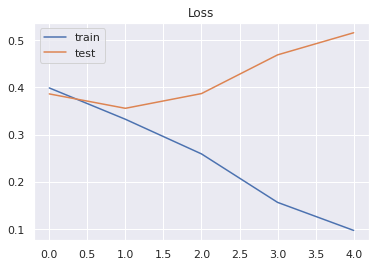

In [ ]:
# create a line graph to show the training and testing loss
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

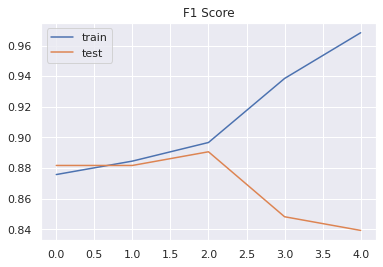

In [ ]:
# create a line graph to show the training and testing accuracy
plt.title('F1 Score')
plt.plot(history.history['get_f1'], label='train')
plt.plot(history.history['val_get_f1'], label='test')
plt.legend()
plt.show();

**LSTM Tuned (F1 Score)**

In [ ]:
# set up a sequential model for the f1 scores
model_f1 = tf.keras.Sequential()
model_f1.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model_f1.add(tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model_f1.add(tf.keras.layers.LSTM(64, return_sequences=True))
model_f1.add(tf.keras.layers.Dense(32, activation='relu'))
model_f1.add(tf.keras.layers.LSTM(16, return_sequences=True))
model_f1.add(tf.keras.layers.SpatialDropout1D(0.2))
model_f1.add(tf.keras.layers.Flatten())
model_f1.add(tf.keras.layers.Dense(2, activation='relu'))
# compile the model using the f1 metric
model_f1.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1])

# how many iterations and the size of data batches
epochs = 10
batch_size = 64

# train the model using the training data
history = model_f1.fit(X_train, 
                    Y_train, 
                    shuffle=True,
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_split=0.1)

Epoch 1/10
56/56 [==============================] - 71s 1s/step - loss: 1.1471 - f1: 0.4119 - val_loss: 0.4425 - val_f1: 0.4680
Epoch 2/10
56/56 [==============================] - 71s 1s/step - loss: 0.5349 - f1: 0.3860 - val_loss: 0.6116 - val_f1: 0.0000e+00
Epoch 3/10
56/56 [==============================] - 71s 1s/step - loss: 0.4808 - f1: 0.4271 - val_loss: 0.4804 - val_f1: 0.4378
Epoch 4/10
56/56 [==============================] - 71s 1s/step - loss: 0.6036 - f1: 0.4640 - val_loss: 0.4593 - val_f1: 0.4127
Epoch 5/10
56/56 [==============================] - 71s 1s/step - loss: 0.4590 - f1: 0.3939 - val_loss: 0.3950 - val_f1: 0.4680
Epoch 6/10
56/56 [==============================] - 71s 1s/step - loss: 0.3852 - f1: 0.4830 - val_loss: 0.4468 - val_f1: 0.4725
Epoch 7/10
56/56 [==============================] - 71s 1s/step - loss: 0.2903 - f1: 0.5313 - val_loss: 0.5990 - val_f1: 0.4843
Epoch 8/10
56/56 [==============================] - 71s 1s/step - loss: 0.2861 - f1: 0.5988 - val_lo

**GRU Tuned (F1 Score)**

In [ ]:
# set up a sequential model for the f1 scores
model_f1 = tf.keras.Sequential()
model_f1.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model_f1.add(tf.keras.layers.GRU(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model_f1.add(tf.keras.layers.GRU(64, return_sequences=True))
model_f1.add(tf.keras.layers.Dense(32, activation='relu'))
model_f1.add(tf.keras.layers.GRU(16, return_sequences=True))
model_f1.add(tf.keras.layers.SpatialDropout1D(0.2))
model_f1.add(tf.keras.layers.Flatten())
model_f1.add(tf.keras.layers.Dense(2, activation='relu'))
# compile the model using the f1 metric
model_f1.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1])

# how many iterations and the size of data batches
epochs = 10
batch_size = 64

# train the model using the training data
history = model_f1.fit(X_train, 
                    Y_train, 
                    shuffle=True,
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_split=0.1)

Epoch 1/10
56/56 [==============================] - 59s 1s/step - loss: 1.4443 - f1: 0.4636 - val_loss: 1.2319 - val_f1: 0.4680
Epoch 2/10
56/56 [==============================] - 58s 1s/step - loss: 0.6946 - f1: 0.4248 - val_loss: 0.4333 - val_f1: 0.4680
Epoch 3/10
56/56 [==============================] - 58s 1s/step - loss: 0.6553 - f1: 0.3601 - val_loss: 1.9274 - val_f1: 0.0000e+00
Epoch 4/10
56/56 [==============================] - 58s 1s/step - loss: 0.8267 - f1: 0.4605 - val_loss: 0.4275 - val_f1: 0.4680
Epoch 5/10
56/56 [==============================] - 58s 1s/step - loss: 0.4453 - f1: 0.4765 - val_loss: 0.4973 - val_f1: 0.4340
Epoch 6/10
56/56 [==============================] - 58s 1s/step - loss: 0.5833 - f1: 0.4611 - val_loss: 0.5637 - val_f1: 0.3482
Epoch 7/10
56/56 [==============================] - 57s 1s/step - loss: 0.3726 - f1: 0.5692 - val_loss: 0.7350 - val_f1: 0.4934
Epoch 8/10
56/56 [==============================] - 58s 1s/step - loss: 0.2854 - f1: 0.6317 - val_lo

**Default LSTM (Accuracy Score)**

In [ ]:
# set up a sequential model for the accuracy scores
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(tf.keras.layers.SpatialDropout1D(0.2))
model.add(tf.keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(tf.keras.layers.Dense(2, activation='softmax'))
# compile the model using the accuracy metric
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, 
                    Y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
56/56 [==============================] - 33s 592ms/step - loss: 0.3981 - accuracy: 0.8774 - val_loss: 0.3772 - val_accuracy: 0.8662
Epoch 2/5
56/56 [==============================] - 33s 589ms/step - loss: 0.3297 - accuracy: 0.8847 - val_loss: 0.3432 - val_accuracy: 0.8687
Epoch 3/5
56/56 [==============================] - 33s 585ms/step - loss: 0.2449 - accuracy: 0.8970 - val_loss: 0.3735 - val_accuracy: 0.8712
Epoch 4/5
56/56 [==============================] - 33s 588ms/step - loss: 0.1544 - accuracy: 0.9400 - val_loss: 0.4709 - val_accuracy: 0.8611
Epoch 5/5
56/56 [==============================] - 33s 590ms/step - loss: 0.0921 - accuracy: 0.9683 - val_loss: 0.5477 - val_accuracy: 0.8384


In [ ]:
# find the loss and accuracy of the network
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

14/14 [==============================] - 1s 47ms/step - loss: 0.6347 - accuracy: 0.8295
Test set
  Loss: 0.635
  Accuracy: 0.830


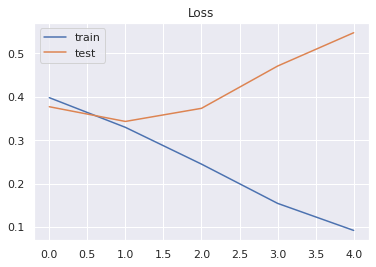

In [ ]:
# create a line graph to show the training and testing loss
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

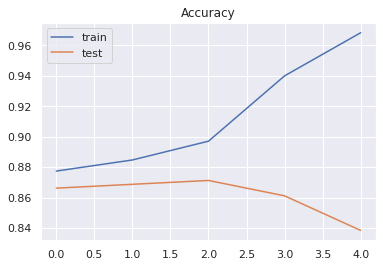

In [ ]:
# create a line graph to show the training and testing accuracy
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
# set up a sequential model for the f1 scores
model_f1 = tf.keras.Sequential()
model_f1.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model_f1.add(tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model_f1.add(tf.keras.layers.LSTM(64, return_sequences=True))
model_f1.add(tf.keras.layers.Dense(32, activation='relu'))
model_f1.add(tf.keras.layers.LSTM(32, return_sequences=True))
#model_f1.add(tf.keras.layers.SpatialDropout1D(0.2))
model_f1.add(tf.keras.layers.LSTM(16, return_sequences=True))
model_f1.add(tf.keras.layers.Flatten())
model_f1.add(tf.keras.layers.Dense(2, activation='relu'))
# compile the model using the f1 metric
model_f1.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1])

# how many iterations and the size of data batches
epochs = 10
batch_size = 64

# train the model using the training data
history = model_f1.fit(X_train, 
                    Y_train, 
                    shuffle=True,
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_split=0.1)

Epoch 1/10
56/56 [==============================] - 83s 1s/step - loss: 2.8363 - f1: 0.5654 - val_loss: 2.0527 - val_f1: 0.7938
Epoch 2/10
56/56 [==============================] - 81s 1s/step - loss: 1.7687 - f1: 0.7963 - val_loss: 2.0527 - val_f1: 0.7938
Epoch 3/10
56/56 [==============================] - 82s 1s/step - loss: 1.7687 - f1: 0.7963 - val_loss: 2.0527 - val_f1: 0.7938
Epoch 4/10
56/56 [==============================] - 82s 1s/step - loss: 1.7687 - f1: 0.7965 - val_loss: 2.0527 - val_f1: 0.7938
Epoch 5/10
56/56 [==============================] - 82s 1s/step - loss: 1.7687 - f1: 0.7963 - val_loss: 2.0527 - val_f1: 0.7938
Epoch 6/10
56/56 [==============================] - 82s 1s/step - loss: 1.7687 - f1: 0.7967 - val_loss: 2.0527 - val_f1: 0.7938
Epoch 7/10
56/56 [==============================] - 81s 1s/step - loss: 1.7687 - f1: 0.7961 - val_loss: 2.0527 - val_f1: 0.7938
Epoch 8/10
56/56 [==============================] - 82s 1s/step - loss: 1.7687 - f1: 0.7965 - val_loss: 

**DistilBert**

In [ ]:
!pip install transformers==2.10.0

     |████████████████████████████████| 665kB 3.4MB/s 
     |████████████████████████████████| 3.8MB 15.8MB/s 
     |████████████████████████████████| 1.1MB 35.5MB/s 
     |████████████████████████████████| 890kB 30.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=f4758591b0deefb4c024a5477b6078a79f89a6c2b3c318a2f0d0c26a29d16572
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
!pip install simpletransformers

     |████████████████████████████████| 215kB 3.3MB/s 
     |████████████████████████████████| 71kB 5.8MB/s 
     |████████████████████████████████| 317kB 8.1MB/s 
     |████████████████████████████████| 1.6MB 12.1MB/s 
     |████████████████████████████████| 1.0MB 31.1MB/s 
     |████████████████████████████████| 7.2MB 14.8MB/s 
     |████████████████████████████████| 122kB 42.2MB/s 
     |████████████████████████████████| 102kB 9.5MB/s 
     |████████████████████████████████| 102kB 9.9MB/s 
     |████████████████████████████████| 163kB 40.9MB/s 
     |████████████████████████████████| 112kB 33.8MB/s 
     |████████████████████████████████| 4.4MB 36.3MB/s 
     |████████████████████████████████| 71kB 7.4MB/s 
     |████████████████████████████████| 122kB 49.2MB/s 
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7423 sha256=4014a345a0f81098b0d9ea47448da51cd55c8ae34251db2e7453fc590a3dbc73
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a8258356

In [ ]:
from simpletransformers.classification import ClassificationModel
from sklearn.model_selection import train_test_split

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [ ]:

# Create a ClassificationModel
model = ClassificationModel('distilbert', 'distilbert-base-uncased', num_labels=2, use_cuda=False)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [ ]:
tweets_df['tweet'] = tweets_df['tweet'].str.lower()

In [ ]:
tweets_df.head()

,tweet,subtask_b
id,,
86426,she should ask a few native americans what th...,1
90194,go home you re drunk #maga #trump,0
62688,someone should'vetaken this piece of shit to...,1
97670,liberals are all kookoo,0
77444,oh noes tough shit,1


In [ ]:
xtrain, ytrain, xvalid, yvalid = train_test_split(tweets_df, tweets_df['subtask_b'], test_size=0.2)

In [ ]:
train_df = pd.DataFrame(xtrain)
eval_df = pd.DataFrame(ytrain)

In [ ]:
# Train the model
model.train_model(xtrain)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:338: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


In [ ]:
from sklearn.metrics import f1_score, accuracy_score


def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='macro')
    
result, model_outputs, wrong_predictions = model.eval_model(eval_df, f1=f1_multiclass, acc=accuracy_score)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:810: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


In [ ]:
result

{'acc': 0.8852272727272728,
 'eval_loss': 0.3296031599017707,
 'f1': 0.571437526218592,
 'fn': 93,
 'fp': 8,
 'mcc': 0.23950719562748107,
 'tn': 766,
 'tp': 13}

**Bert**

In [ ]:
# Create a ClassificationModel
model_bert = ClassificationModel('bert', 'bert-base-uncased', num_labels=2, use_cuda=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
xtrain, ytrain, xvalid, yvalid = train_test_split(tweets_df, tweets_df['subtask_b'], test_size=0.2)

In [ ]:
train_df = pd.DataFrame(xtrain)
eval_df = pd.DataFrame(ytrain)

In [ ]:
# Train the model
model_bert.train_model(xtrain)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:338: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


In [ ]:
from sklearn.metrics import f1_score, accuracy_score

def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='macro')
    
result, model_outputs, wrong_predictions = model_bert.eval_model(eval_df, f1=f1_multiclass, acc=accuracy_score)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:810: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


In [ ]:
result

{'acc': 0.8931818181818182,
 'eval_loss': 0.308089411936023,
 'f1': 0.5442424242424242,
 'fn': 88,
 'fp': 6,
 'mcc': 0.1885616496145903,
 'tn': 778,
 'tp': 8}

**Flair**

In [ ]:
!pip install flair

     |████████████████████████████████| 337kB 3.1MB/s 
     |████████████████████████████████| 19.7MB 42.2MB/s 
     |████████████████████████████████| 798kB 38.2MB/s 
     |████████████████████████████████| 276kB 43.2MB/s 
     |████████████████████████████████| 71kB 7.5MB/s 
     |████████████████████████████████| 983kB 39.5MB/s 
     |████████████████████████████████| 3.0MB 35.9MB/s 
  Created wheel for mpld3: filename=mpld3-0.3-cp36-none-any.whl size=116677 sha256=a77cb4a8110445561bf9b0f002802b2ed53eca3d59a56f3a66e530eda08f186f
  Stored in directory: /root/.cache/pip/wheels/c0/47/fb/8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
  Created wheel for sqlitedict: filename=sqlitedict-1.7.0-cp36-none-any.whl size=14377 sha256=1cd4a1888ec13ed2e03b7b1f00d4137c18d083fcb77cc46f37621ed2661abb8b
  Stored in directory: /root/.cache/pip/wheels/cf/c6/4f/2c64a43f041415eb8b8740bd80e15e92f0d46c5e464d8e4b9b
  Created wheel for segtok: filename=segtok-1.5.10-cp36-none-any.whl size=25021 sha256=3e

In [ ]:
import flair
import torch

In [ ]:
data = pd.read_csv("drive/My Drive/OLIDv1.0/olid-training-v1.0.tsv", encoding='latin-1', error_bad_lines=False).sample(frac=1).drop_duplicates()
 
data = tweets_df[['tweet', 'subtask_b']].rename(columns={"tweet":"text", "subtask_b":"labels"})
 
data['labels'] = '__labels__' + data['labels'].astype(str)
 
data.iloc[0:int(len(data)*0.8)].to_csv('train.csv', sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.8):int(len(data)*0.9)].to_csv('test.csv', sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.9):].to_csv('dev.csv', sep='\t', index = False, header = False);

b'Skipping line 42: expected 1 fields, saw 2\nSkipping line 113: expected 1 fields, saw 5\nSkipping line 135: expected 1 fields, saw 3\nSkipping line 148: expected 1 fields, saw 3\nSkipping line 176: expected 1 fields, saw 2\nSkipping line 182: expected 1 fields, saw 2\nSkipping line 193: expected 1 fields, saw 3\nSkipping line 229: expected 1 fields, saw 2\nSkipping line 235: expected 1 fields, saw 3\nSkipping line 273: expected 1 fields, saw 2\nSkipping line 298: expected 1 fields, saw 3\nSkipping line 319: expected 1 fields, saw 2\nSkipping line 323: expected 1 fields, saw 2\nSkipping line 349: expected 1 fields, saw 3\nSkipping line 423: expected 1 fields, saw 3\nSkipping line 430: expected 1 fields, saw 2\nSkipping line 449: expected 1 fields, saw 3\nSkipping line 488: expected 1 fields, saw 3\nSkipping line 523: expected 1 fields, saw 3\nSkipping line 539: expected 1 fields, saw 4\nSkipping line 544: expected 1 fields, saw 2\nSkipping line 578: expected 1 fields, saw 3\nSkipping 

In [ ]:
from flair.data import Corpus
from flair.datasets import CSVClassificationCorpus

data_folder = ''
column_name_map = {0: "text", 1: "labels"}

corpus: Corpus = CSVClassificationCorpus(data_folder,
                                         column_name_map,
                                         skip_header=False,
                                         delimiter='\t') 
label_dict = corpus.make_label_dictionary()
len(corpus.dev)

2020-09-28 09:35:51,818 Reading data from .
2020-09-28 09:35:51,827 Train: train.csv
2020-09-28 09:35:51,831 Dev: dev.csv
2020-09-28 09:35:51,833 Test: test.csv
2020-09-28 09:35:51,852 Computing label dictionary. Progress:


100%|██████████| 3960/3960 [00:03<00:00, 1091.67it/s]

2020-09-28 09:35:55,779 [b'__labels__1', b'__labels__0']


440

In [ ]:
from flair.data import Corpus
from flair.datasets import TREC_6
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer


# 1. get the corpus
#corpus: Corpus = TREC_6()

# 2. create the label dictionary
label_dict = corpus.make_label_dictionary()

# 3. make a list of word embeddings
word_embeddings = [WordEmbeddings('en-twitter')]

# 4. initialize document embedding by passing list of word embeddings
# Can choose between many RNN types (GRU by default, to change use rnn_type parameter)
document_embeddings = DocumentRNNEmbeddings(word_embeddings, hidden_size=256)

# 5. create the text classifier
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict)

# 6. initialize the text classifier trainer
trainer = ModelTrainer(classifier, corpus)

# 7. start the training
trainer.train('resources/taggers/trec',
              learning_rate=0.1,
              mini_batch_size=32,
              anneal_factor=0.5,
              patience=5,
              max_epochs=10)

2020-09-28 09:35:59,884 Computing label dictionary. Progress:


100%|██████████| 3960/3960 [00:03<00:00, 1064.48it/s]

2020-09-28 09:36:03,865 [b'__labels__1', b'__labels__0']


2020-09-28 09:36:04,388 https://flair.informatik.hu-berlin.de/resources/embeddings/token/twitter.gensim.vectors.npy not found in cache, downloading to /tmp/tmp_b9qlz9y


100%|██████████| 477405728/477405728 [00:42<00:00, 11222697.64B/s]

2020-09-28 09:36:47,353 copying /tmp/tmp_b9qlz9y to cache at /root/.flair/embeddings/twitter.gensim.vectors.npy


2020-09-28 09:36:48,962 removing temp file /tmp/tmp_b9qlz9y
2020-09-28 09:36:49,723 https://flair.informatik.hu-berlin.de/resources/embeddings/token/twitter.gensim not found in cache, downloading to /tmp/tmp_8qx2zyo


100%|██████████| 68268001/68268001 [00:03<00:00, 18660529.08B/s]

2020-09-28 09:36:53,818 copying /tmp/tmp_8qx2zyo to cache at /root/.flair/embeddings/twitter.gensim
2020-09-28 09:36:53,906 removing temp file /tmp/tmp_8qx2zyo



/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


2020-09-28 09:36:59,090 ----------------------------------------------------------------------------------------------------
2020-09-28 09:36:59,092 Model: "TextClassifier(
  (document_embeddings): DocumentRNNEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): WordEmbeddings('en-twitter')
    )
    (word_reprojection_map): Linear(in_features=100, out_features=100, bias=True)
    (rnn): GRU(100, 256, batch_first=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Linear(in_features=256, out_features=2, bias=True)
  (loss_function): CrossEntropyLoss()
  (beta): 1.0
  (weights): None
  (weight_tensor) None
)"
2020-09-28 09:36:59,097 ----------------------------------------------------------------------------------------------------
2020-09-28 09:36:59,099 Corpus: "Corpus: 3520 train + 440 dev + 440 test sentences"
2020-09-28 09:36:59,100 ----------------------------------------------------------------------------------------------------
2020-09-28 09

{'dev_loss_history': [0.3871627748012543,
  0.3980252742767334,
  0.384809672832489,
  0.3844846785068512,
  0.3807831406593323,
  0.3778463900089264,
  0.39324966073036194,
  0.3865102231502533,
  0.38982531428337097,
  0.3844764232635498],
 'dev_score_history': [0.8659,
  0.8659,
  0.8659,
  0.8659,
  0.8659,
  0.8659,
  0.8659,
  0.8659,
  0.8659,
  0.8659],
 'test_score': 0.8977,
 'train_loss_history': [0.38751645779067817,
  0.36614005531777033,
  0.3627043108371171,
  0.35457562601024456,
  0.351818817041137,
  0.3511836988004771,
  0.350910666517236,
  0.3487862600521608,
  0.346287296035073,
  0.342413711480119]}

In [ ]:
from flair.data import Sentence
classifier = TextClassifier.load('resources/taggers/trec/best-model.pt')

# create example sentence
sentence = Sentence('i love you')

# predict class and print
classifier.predict(sentence)

print(sentence.labels)

2020-09-28 09:42:20,438 loading file resources/taggers/trec/best-model.pt
[__labels__0 (0.8584)]


**Rescaling the Data with Tf-idf**

In [ ]:
text_train, y_train = tweets_df.tweet, tweets_df.subtask_b

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
pipe = make_pipeline(TfidfVectorizer(min_df=5),
                     LogisticRegression())
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidfvectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=5,
                                                        ngram_range=(1, 1),
                                               

In [ ]:
from sklearn.model_selection import GridSearchCV
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
X_train = vectorizer.transform(tweets_df['tweet'])
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
feature_names = np.array(vectorizer.get_feature_names())

In [ ]:
print("Features with the lowest tfidf: \n{}".format(
    feature_names[sorted_by_tfidf[:20]]
))

Features with the lowest tfidf: 
['predator' 'brett' 'steal' 'rd' 'honorable' 'smear' 'killers' 'arguing'
 'covered' 'system' 'planned' 'scare' 'willing' 'govt' 'turning'
 'assaulted' 'sea' 'united' 'luck' 'concerned']


In [ ]:
print("Features with the highest tfidf: \n{}".format(
    feature_names[sorted_by_tfidf[-20:]]
))

Features with the highest tfidf: 
['and' 'crook' 'pussy' 'gross' 'black' 'absolutely' 'fucking' 'horrible'
 'antifa' 'fucker' 'fuck' 'bullshit' 'disgusting' 'awful' 'be' 'damn' 'in'
 'sexy' 'hypocritical' 'im']


In [ ]:
!pip install mglearn

     |████████████████████████████████| 542kB 4.5MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582638 sha256=86a1042b59f939ed2dc1b6340cdec0f873901a113773fd7ab4bc3b5069c23b98
  Stored in directory: /root/.cache/pip/wheels/eb/a6/ea/a6a3716233fa62fc561259b5cb1e28f79e9ff3592c0adac5f0
Successfully built mglearn


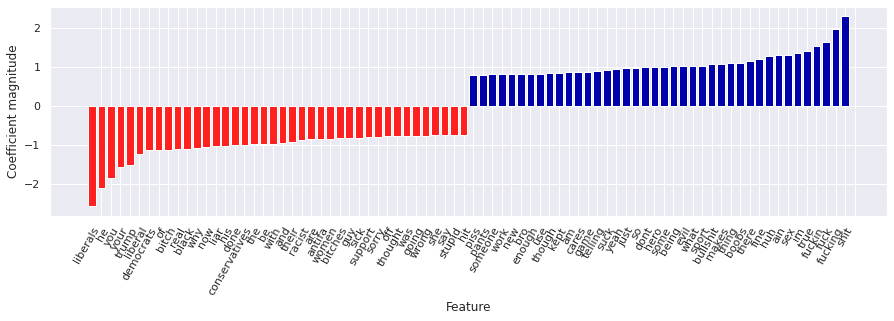

In [ ]:
import mglearn
mglearn.tools.visualize_coefficients(
    grid.best_estimator_.named_steps["logisticregression"].coef_,
    feature_names, n_top_features=40
)

**Spacy**

In [ ]:
import spacy
import sklearn
import nltk

In [ ]:
en_nlp = spacy.load('en')
stemmer = nltk.stem.PorterStemmer()

In [ ]:
def compare_normalization(doc):
  doc_spacy = en_nlp(doc)
  print("Lemmenisation:")
  print([token.lemma_ for token in doc_spacy])
  print("Stemming:")
  print([stemmer.stem(token.norm_.lower()) for token in doc_spacy])

In [ ]:
import re
regexp = re.compile('(?u)\\b\\w\\w+\\b')

In [ ]:
en_nlp = spacy.load('en', disable=['parser', 'ner'])
old_tokenizer = en_nlp.tokenizer

In [ ]:
en_nlp.tokenizer = lambda string: old_tokenizer.tokens_from_list(
    regexp.findall(string)
)

In [ ]:
def custome_tokenizer(document):
  doc_spacy = en_nlp(document)
  return [token.lemma_ for token in doc_spacy]

In [ ]:
lemma_vect = CountVectorizer(tokenizer=custome_tokenizer, min_df=5)

In [ ]:
X_train_lemma = lemma_vect.fit_transform(text_train)
print("X_train_lemma.shape: {}".format(X_train_lemma.shape))

vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print("X_train.shape: {}".format(X_train.shape))

X_train_lemma.shape: (4400, 1707)
X_train.shape: (4400, 1944)


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.99, train_size=0.01, random_state=0)
grid = GridSearchCV(LogisticRegression(),param_grid, cv=cv)
grid.fit(X_train, y_train)
print("Best cross-validation score (Standard CountVectorizer): {:.3f}".format(grid.best_score_))

grid.fit(X_train_lemma, y_train)
print("Best cross-validation score (Lemmatization): {:.3f}".format(grid.best_score_))

Best cross-validation score (Standard CountVectorizer): 0.881
Best cross-validation score (Lemmatization): 0.881


**Latent Dirichlet Allocation**

In [ ]:
vect = TfidfVectorizer(max_features=10000, max_df=.15)
X = vect.fit_transform(text_train)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10, learning_method='batch', max_iter=25, random_state=0)
document_topics = lda.fit_transform(X)

In [ ]:
print("lds.components_.shape: {}".format(lda.components_.shape))

In [ ]:
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())

In [ ]:
mglearn.tools.print_topics(topics=range(10), 
                           feature_names=feature_names, 
                           sorting=sorting, 
                           topics_per_chunk=5, 
                           n_words=10)

In [ ]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(tweets_df['tweet'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [ ]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 10
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)